In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import csv
import math

In [12]:
# ROBERTA
train = pd.read_csv('data//roberta//roberta.train.csv')
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]

test = pd.read_csv('data//roberta//roberta.test.csv')
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1:]

eval_df = pd.read_csv('data//roberta//roberta.eval.anon.csv')
eval_df = eval_df.iloc[:,:-1]


In [13]:
train_y = train_y.replace(0, -1)
test_y = test_y.replace(0, -1)

In [16]:
def prediction(x, y, w):
    pred = np.dot(w.transpose(), x)
    if (pred > 0 and y == 1) or (pred <= 0 and y == -1):
        return True
    else:
        return False

def accuracy(feature_df, label_df, w):
    size = feature_df.shape[0]
    count = 0
    for i in range(size):
        x = feature_df.iloc[i].tolist()
        y = label_df.iloc[i].tolist()[0]
        if prediction(x, y, w):
            count += 1
    return (count/size)

def prediction_value(x, w):
    pred = np.dot(w.transpose(), x)
    if pred > 0:
        return 1
    else:
        return 0

def get_predicted_list(feature_df, w):
    pred_list = []
    size = feature_df.shape[0]
    count = 0
    for i in range(size):
        x = feature_df.iloc[i].tolist()
        pred_list.append(prediction_value(x, w))
    return pred_list

def generate_w(size):
    np.random.seed(65)
    w = np.array(np.random.normal(-0.01, 0.01, size))
    return w

def update_w(x, y, w, lr, c, update_count):
    eq = y*(np.dot(w.transpose(), x))
    if eq <= 1:
        w = w*(1-(2*lr/c)) + (lr*y*x/(1 + math.exp(eq)))
    else:
        w = w*(1-(2*lr/c))
    update_count += 1
    return w, update_count

def perceptron(features, labels, w, lr, epochs, c=0, dev=False, test_df_x=None, test_df_y=None):
    w_list = []
    update_count = 0
    accuracies_list = []
    index_list = np.arange(features.shape[0])
    for e in range(epochs):
        new_lr = (lr/(1+e))
        np.random.seed(e)
        np.random.shuffle(index_list)
        for i in index_list:
            x = features.iloc[i]
            y = labels.iloc[i].tolist()[0]
            w, update_count = update_w(x, y, w, new_lr, c, update_count)
        if dev:
            w_list.append(w.copy())
            acc = accuracy(test_df_x, test_df_y, w)
            accuracies_list.append(acc)
            print("Developmental dataset accuracy for epoch", e, "=", acc)
    return w, accuracies_list, update_count, w_list

In [17]:
#CROSS VALIDATION

train_length = int(train_x.shape[0]*4//5)
test_length = train_x.shape[0] - train_length

train_x_fold = train_x.head(train_length)
train_y_fold = train_y.head(train_length)

test_x_fold = train_x.tail(test_length)
test_y_fold = train_y.tail(test_length)

k = 5

lrs = [0.1, 0.01, 0.001, 0.0001]
tradeoff = [0.1, 1, 10, 100, 1000]

epochs = 20
accuracies = {(lr, c): [] for lr in lrs for c in tradeoff}
for lr in lrs:
    for c in tradeoff:
        print("Lr:", lr, "C:", c)
        w = generate_w(train_x_fold.shape[1])
        w, accuracies_list, update_count, w_list = perceptron(train_x_fold, train_y_fold, w, lr, epochs, c)
        acc = accuracy(test_x_fold, test_y_fold, w)
        accuracies[lr, c] = acc


for i in lrs:
    for j in tradeoff:
        print("Averaged test accuracy for (learning rate, tradeoff):(",i,j,"):",accuracies[(i,j)])
        print()

best_lr_c = max(accuracies, key=lambda x: accuracies[x])
print("(LR, m) pair with highest accuracy:", best_lr_c)
print("Accuracy with the best learning rate, tradeoff pair:",accuracies[best_lr_c])

Lr: 0.1 C: 0.1
Lr: 0.1 C: 1
Lr: 0.1 C: 10
Lr: 0.1 C: 100
Lr: 0.1 C: 1000
Lr: 0.01 C: 0.1
Lr: 0.01 C: 1
Lr: 0.01 C: 10
Lr: 0.01 C: 100
Lr: 0.01 C: 1000
Lr: 0.001 C: 0.1
Lr: 0.001 C: 1
Lr: 0.001 C: 10
Lr: 0.001 C: 100
Lr: 0.001 C: 1000
Lr: 0.0001 C: 0.1
Lr: 0.0001 C: 1
Lr: 0.0001 C: 10
Lr: 0.0001 C: 100
Lr: 0.0001 C: 1000
Averaged test accuracy for (learning rate, tradeoff):( 0.1 0.1 ): 0.5021156558533145

Averaged test accuracy for (learning rate, tradeoff):( 0.1 1 ): 0.5021156558533145

Averaged test accuracy for (learning rate, tradeoff):( 0.1 10 ): 0.5021156558533145

Averaged test accuracy for (learning rate, tradeoff):( 0.1 100 ): 0.5035260930888575

Averaged test accuracy for (learning rate, tradeoff):( 0.1 1000 ): 0.7849083215796897

Averaged test accuracy for (learning rate, tradeoff):( 0.01 0.1 ): 0.4978843441466855

Averaged test accuracy for (learning rate, tradeoff):( 0.01 1 ): 0.4978843441466855

Averaged test accuracy for (learning rate, tradeoff):( 0.01 10 ): 0.4978843441

Developmental dataset accuracy for epoch 0 = 0.4978843441466855
Developmental dataset accuracy for epoch 1 = 0.5021156558533145
Developmental dataset accuracy for epoch 2 = 0.5021156558533145
Developmental dataset accuracy for epoch 3 = 0.573342736248237
Developmental dataset accuracy for epoch 4 = 0.5021156558533145
Developmental dataset accuracy for epoch 5 = 0.5246826516220028
Developmental dataset accuracy for epoch 6 = 0.578984485190409
Developmental dataset accuracy for epoch 7 = 0.8018335684062059
Developmental dataset accuracy for epoch 8 = 0.5049365303244006
Developmental dataset accuracy for epoch 9 = 0.5267983074753173
Developmental dataset accuracy for epoch 10 = 0.5105782792665726
Developmental dataset accuracy for epoch 11 = 0.7101551480959097
Developmental dataset accuracy for epoch 12 = 0.7454160789844851
Developmental dataset accuracy for epoch 13 = 0.6212976022566996
Developmental dataset accuracy for epoch 14 = 0.5923836389280677
Developmental dataset accuracy for ep

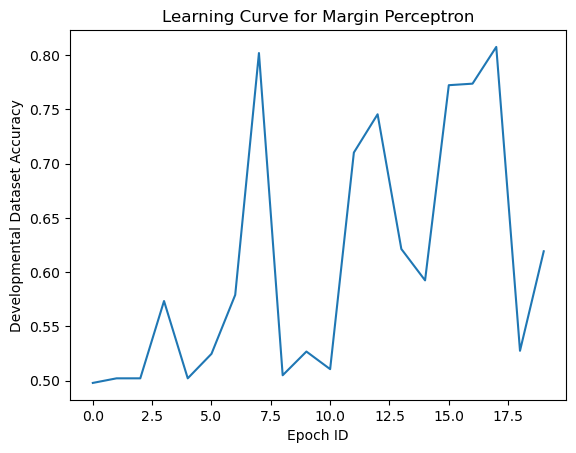

In [18]:
lr = best_lr_c[0]
c = best_lr_c[1]
epochs = 20
w = generate_w(train_x.shape[1])
w, accuracies_list, update_count, w_list = perceptron(train_x, train_y, w, lr, epochs, c, True, test_x_fold, test_y_fold)

print()
print("Total number of updates on training set:", update_count)
print("Max accuracy in developmental dataset:", max(accuracies_list))
index = accuracies_list.index(max(accuracies_list))
print("Max accuracy in developmental dataset was found at epoch number:", index)
best_w = w_list[index]
# best_b = b_list[index]
print("Train accuracy with w and b corresponding to best accuracy for dev dataset =", accuracy(train_x, train_y, best_w))
print("Test accuracy with w and b corresponding to best accuracy for dev dataset =", accuracy(test_x, test_y, best_w))
print()

x_axis = [i for i in range(len(accuracies_list))]
y_axis = accuracies_list

plt.plot(x_axis, y_axis)
plt.xlabel("Epoch ID")
plt.ylabel("Developmental Dataset Accuracy")
plt.title("Learning Curve for Margin Perceptron")
if os.path.isfile("svm-sgd.png"):
    os.remove("svm-sgd.png")
plt.savefig("svm-sgd.png")
plt.show(block=False)

In [19]:
pred = get_predicted_list(eval_df, best_w)

In [20]:
file = open('4_lr_roberta_65s_20e.csv', 'w', newline ='')

with file:
    header = ['example_id', 'label']
    writer = csv.DictWriter(file, fieldnames = header)

    writer.writeheader()
    for i in range(len(pred)):
        writer.writerow({'example_id' : i, 'label': pred[i]})